# 2. Modeling with US State granularity

We can use epymorph's ADRIO system to dynamically fetch data from external data sources to suit our modeling experiment.

First we describe the scope of our geography, then we will run simulations with two movement models and inspect the difference.

We constructed the SIRH model ourselves in the previous part, but epymorph's IPM library already includes it, so we can reference it from there as well.

In [1]:
from epymorph.kit import *

scope = StateScope.in_states(["AZ", "NM", "CO", "UT"], year=2020)

print(f"nodes: {scope.nodes}")
print(f"geoid: {scope.node_ids.tolist()}")

nodes: 4
geoid: ['04', '08', '35', '49']


## Centroids movement

Our first movement model is a simple distance kernel using node centroid coordinates (longitude/latitude).

Loading epymorph.adrio.acs5.Population:
  |####################| 100%  (1.328s)
Loading epymorph.adrio.us_tiger.GeometricCentroid:
  |####################| 100%  (1.691s)
Loading epymorph.adrio.us_tiger.Name:
  |####################| 100%  (0.082s)
Running simulation (BasicSimulator):
• 2020-01-01 to 2020-05-30 (150 days)
• 4 geo nodes
  |####################| 100%                     
Runtime: 0.109s


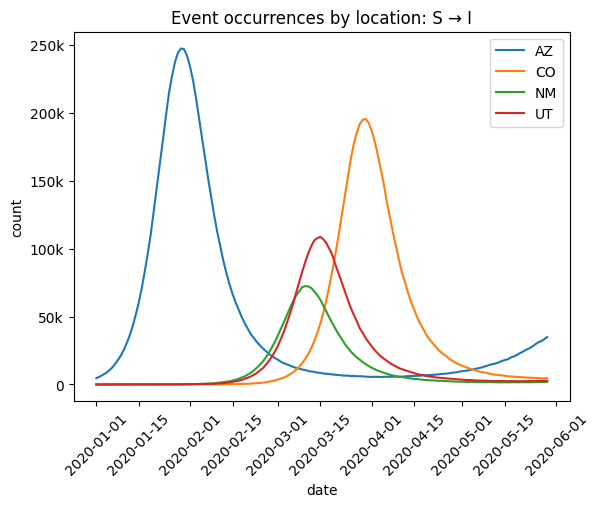

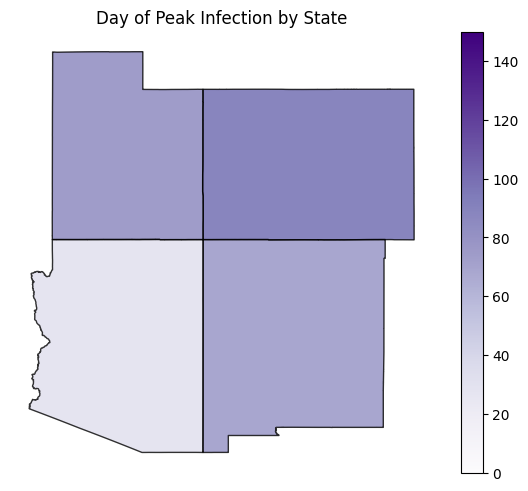

In [2]:
import numpy as np
import pandas as pd

from epymorph.adrio import acs5, us_tiger
from epymorph.simulator.basic.output import Output

rume = SingleStrataRume.build(
    ipm=ipm.Sirh(),
    mm=mm.Centroids(),
    scope=scope,
    params={
        "beta": 0.45,
        "gamma": 0.25,
        "xi": 0.0111,
        "hospitalization_prob": 0.1,
        "hospitalization_duration": 7.0,
        "phi": 40.0,
        "population": acs5.Population(),
        "centroid": us_tiger.GeometricCentroid(),
        "meta::geo::label": us_tiger.Name(),
    },
    time_frame=TimeFrame.of("2020-01-01", 150),
    # Initialize the infection in Arizona with 10k individuals.
    # Arizona is the node at index 0 because it has the lowest
    # FIPS code of the states we selected.
    init=init.SingleLocation(location=0, seed_size=10_000),
)

sim = BasicSimulator(rume)
with sim_messaging():
    output = sim.run()

output.plot.line(
    geo=rume.scope.select.all(),
    time=rume.time_frame.select.all().group("day").agg(),
    quantity=rume.ipm.select.events("S->I"),
    title="Event occurrences by location: S → I",
    label_format="{n}",
)


# To show peak date of infection on a choropleth map using our built-in map function,
# we need to cheat a bit. We're going to provide a "transform" function which really
# just swaps the data for the values we want to show.
# To calculate the peak date, we need the raw simulation results data. So this outer
# function captures the output object and returns the transform function that uses it.
def peak_date_transform(output: Output):
    def peak_date(data_df: pd.DataFrame) -> pd.DataFrame:
        EVENT_S_TO_I = rume.ipm.select.events("S->I").event_index
        # argmax gives us an index, but the index is equal to the tau step index
        # so just need to floor-div by number of tau steps to get day
        day_of_peak_infection = np.array(
            [
                float(np.argmax(output.events[:, n, EVENT_S_TO_I]))
                // output.dim.tau_steps
                for n in range(scope.nodes)
            ]
        )

        return data_df.copy(deep=False).assign(data=day_of_peak_infection)

    return peak_date


output.map.choropleth(
    geo=rume.scope.select.all(),
    time=rume.time_frame.select.all().agg(),
    quantity=rume.ipm.select.events("S->I"),
    borders=rume.scope.select.all(),
    transform=peak_date_transform(output),
    title="Day of Peak Infection by State",
    vmin=0,
    vmax=output.dim.days,
    cmap="Purples",
)

## Commuters movement

Now switch to a different movement model, incorporating the Census Bureau's ACS Commuting Flows data, and run the simulation again.

Loading epymorph.adrio.commuting_flows.Commuters:
  |####################| 100%  (6.398s)
Loading epymorph.adrio.acs5.Population:
  |####################| 100%  (0.553s)
Loading epymorph.adrio.us_tiger.Name:
  |####################| 100%  (0.089s)
Running simulation (BasicSimulator):
• 2020-01-01 to 2020-05-30 (150 days)
• 4 geo nodes
  |####################| 100%                     
Runtime: 0.127s


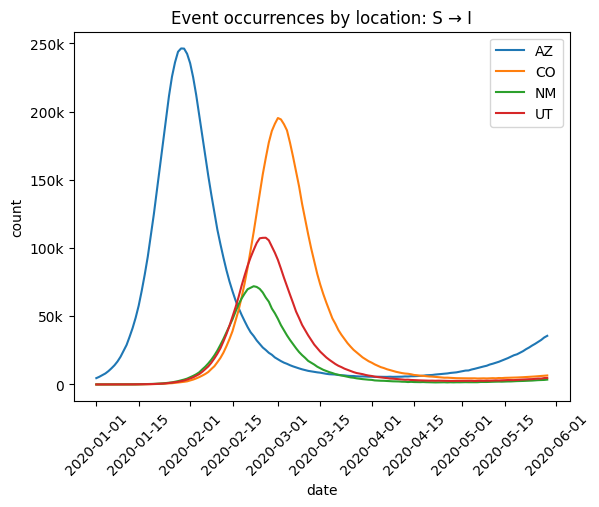

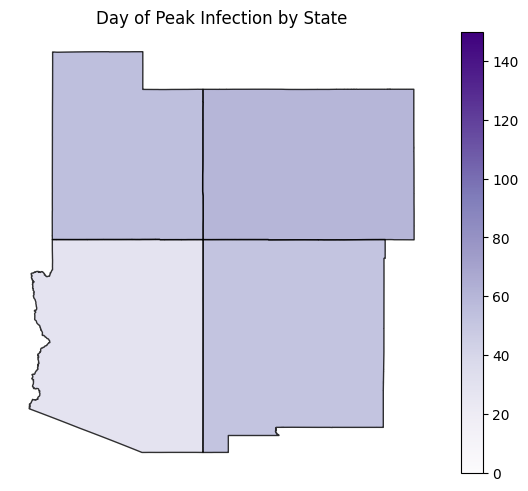

In [3]:
from epymorph.kit import *
from epymorph.adrio import acs5, commuting_flows, us_tiger

rume = SingleStrataRume.build(
    ipm=ipm.Sirh(),
    mm=mm.Pei(),
    scope=scope,
    params={
        "beta": 0.45,
        "gamma": 0.25,
        "xi": 0.0111,
        "hospitalization_prob": 0.1,
        "hospitalization_duration": 7.0,
        "move_control": 0.9,
        "theta": 0.1,
        "population": acs5.Population(),
        "centroid": us_tiger.GeometricCentroid(),
        "commuters": commuting_flows.Commuters(),
        "meta::geo::label": us_tiger.Name(),
    },
    time_frame=TimeFrame.of("2020-01-01", 150),
    # Initialize the infection in Arizona with 10k individuals.
    init=init.SingleLocation(location=0, seed_size=10_000),
)

sim = BasicSimulator(rume)
with sim_messaging():
    output = sim.run()

output.plot.line(
    geo=rume.scope.select.all(),
    time=rume.time_frame.select.all().group("day").agg(),
    quantity=rume.ipm.select.events("S->I"),
    title="Event occurrences by location: S → I",
    label_format="{n}",
)

output.map.choropleth(
    geo=rume.scope.select.all(),
    time=rume.time_frame.select.all().agg(),
    quantity=rume.ipm.select.events("S->I"),
    borders=rume.scope.select.all(),
    # Here we re-use the peak date function we wrote in the last part
    transform=peak_date_transform(output),
    title="Day of Peak Infection by State",
    vmin=0,
    vmax=output.dim.days,
    cmap="Purples",
)